In [1]:
import sys; sys.path.append('../../src/playground_jax')
from time import time

from jax import numpy as jnp, random, nn
from jax import grad, value_and_grad, vmap, jit
from jax.tree_util import tree_map
from jaxtyping import Array, PyTree
import flax
import optax
import matplotlib.pyplot as plt

from models_flax import *

Goal: fit a scalar real-valued funciton
$ f: D \subset \mathbb{R} \rightarrow \mathbb{R}$

1. Generate training data

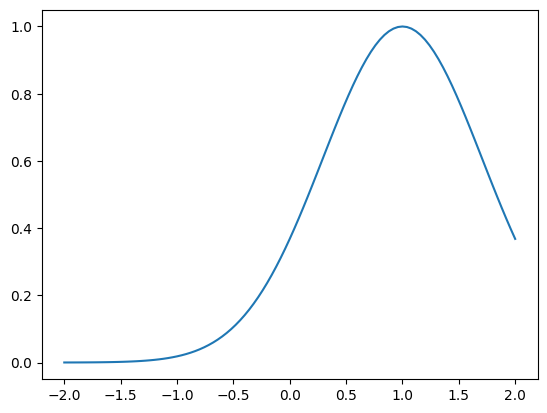

In [2]:
N = 101
x = jnp.expand_dims(jnp.linspace(-2, 2, N), axis=-1)
y = jnp.exp(-(x - 1)**2)
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

2. build a model

In [3]:
# set a random key
key = random.PRNGKey(1)

# define model
d_in = 1
n_gauss = 6
means = jnp.linspace(-2, 2, n_gauss).reshape(n_gauss, d_in)
sigma = 1.
cov = sigma * jnp.eye(d_in)
sigma_i = jnp.diagonal(cov)

model = GaussianAnsatz(means, cov)

# initialize variables
key, split = random.split(key)
input = jnp.ones(d_in)
params = model.init(key, input)
tree_map(lambda x: x.shape, params)
#params

{'params': {'Dense_0': {'kernel': (6, 1)}}}

In [4]:
# evaluate model
batch_size = int(1e3)
input = random.normal(key, (batch_size, d_in), jnp.float32) 
vmap(model.apply, in_axes=(None, 0))(params, input).shape

(1000, 1)

3. Define loss (mean square error loss)

In [5]:
@jit
def loss_fn(params: flax.core.frozen_dict.FrozenDict, x, y):
    pred_y = vmap(model.apply, in_axes=(None, 0))(params, x)
    return jnp.mean((y - pred_y) ** 2)

4. Choose optimizer

In [6]:
lr = 1e-1
wd = 1e-5

# using optax
opt = optax.adamw(learning_rate=lr, weight_decay=wd)
opt_state = opt.init(params)

5. Update function

In [7]:
@jit
def update_fn(params, opt_state: PyTree, x: Array, y: Array):
    
    # compute gradients and loss value
    loss, grads = value_and_grad(loss_fn)(params, x, y)
    print(grads)

    # optimizer upate
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [8]:
x.shape, y.shape

((101, 1), (101, 1))

6. Train

In [9]:
n_iter = int(1e4)
log_period_iter = int(1e3)
for i in range(n_iter):
    t0 = time()
    loss, params, opt_state = update_fn(params, opt_state, x, y)
    t1 = time()
    if i % log_period_iter  == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

{'params': {'Dense_0': {'kernel': Traced<ShapedArray(float32[6,1])>with<DynamicJaxprTrace(level=1/0)>}}}
it: 0, loss: 3.704e-01, time: 0.0702s
it: 1000, loss: 1.958e-04, time: 0.0000s
it: 2000, loss: 1.546e-04, time: 0.0000s
it: 3000, loss: 1.262e-04, time: 0.0000s
it: 4000, loss: 1.155e-04, time: 0.0000s
it: 5000, loss: 1.080e-04, time: 0.0000s
it: 6000, loss: 1.074e-04, time: 0.0000s
it: 7000, loss: 1.073e-04, time: 0.0000s
it: 8000, loss: 1.073e-04, time: 0.0000s
it: 9000, loss: 1.073e-04, time: 0.0000s


7. Evaluate results

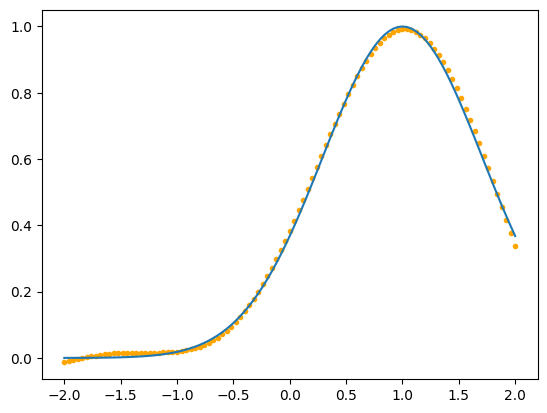

In [10]:
#y_pred = model.apply(params, x)
y_pred = vmap(model.apply, in_axes=(None, 0))(params, x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter(x, y_pred, c='orange', marker='.')
plt.show()